<a href="https://colab.research.google.com/github/harrisonxia/Predictive-Maintenance/blob/master/iot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [14]:
!pip install tensorflow
!pip install pandas

You should consider upgrading via the 'C:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
!pip install matplotlib

You should consider upgrading via the 'C:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.1-cp39-cp39-win_amd64.whl (11.0 MB)
     -------------------------------------- 301.8/301.8 KB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 2.0 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


Index(['TimeStamp', '::[scararobot]Ax_J1.ActualPosition',
       '::[scararobot]Ax_J1.PositionCommand',
       '::[scararobot]Ax_J1.PositionError',
       '::[scararobot]Ax_J1.TorqueCommand',
       '::[scararobot]Ax_J1.TorqueFeedback',
       '::[scararobot]Ax_J2.ActualPosition',
       '::[scararobot]Ax_J2.PositionCommand',
       '::[scararobot]Ax_J2.PositionError',
       '::[scararobot]Ax_J2.TorqueCommand',
       '::[scararobot]Ax_J2.TorqueFeedback',
       '::[scararobot]Ax_J3.ActualPosition',
       '::[scararobot]Ax_J3.PositionCommand',
       '::[scararobot]Ax_J3.PositionError',
       '::[scararobot]Ax_J3.TorqueCommand',
       '::[scararobot]Ax_J3.TorqueFeedback',
       '::[scararobot]Ax_J6.ActualPosition',
       '::[scararobot]Ax_J6.PositionCommand',
       '::[scararobot]Ax_J6.PositionError',
       '::[scararobot]Ax_J6.TorqueCommand',
       '::[scararobot]Ax_J6.TorqueFeedback',
       '::[scararobot]CS_Cartesian.ActualPosition[0]',
       '::[scararobot]CS_Cartesian.A

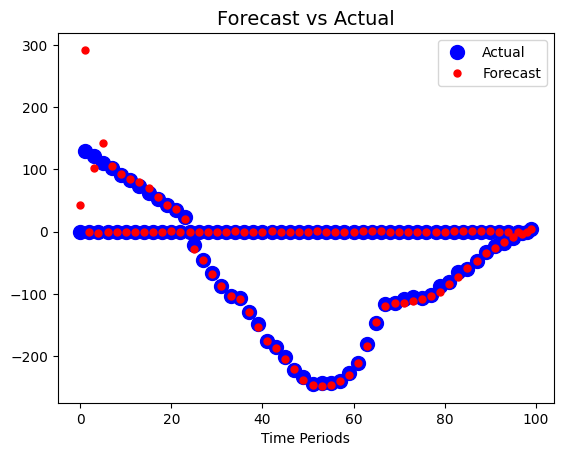

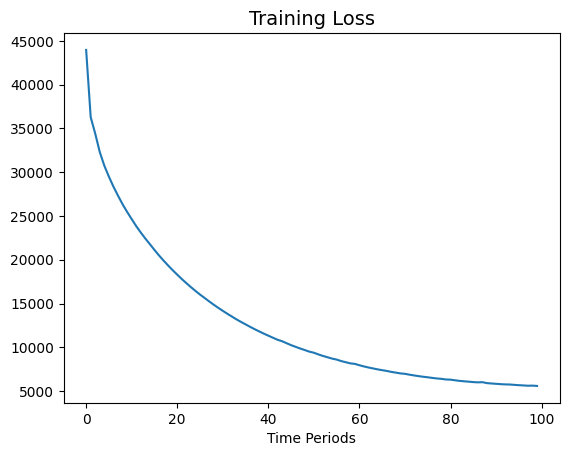

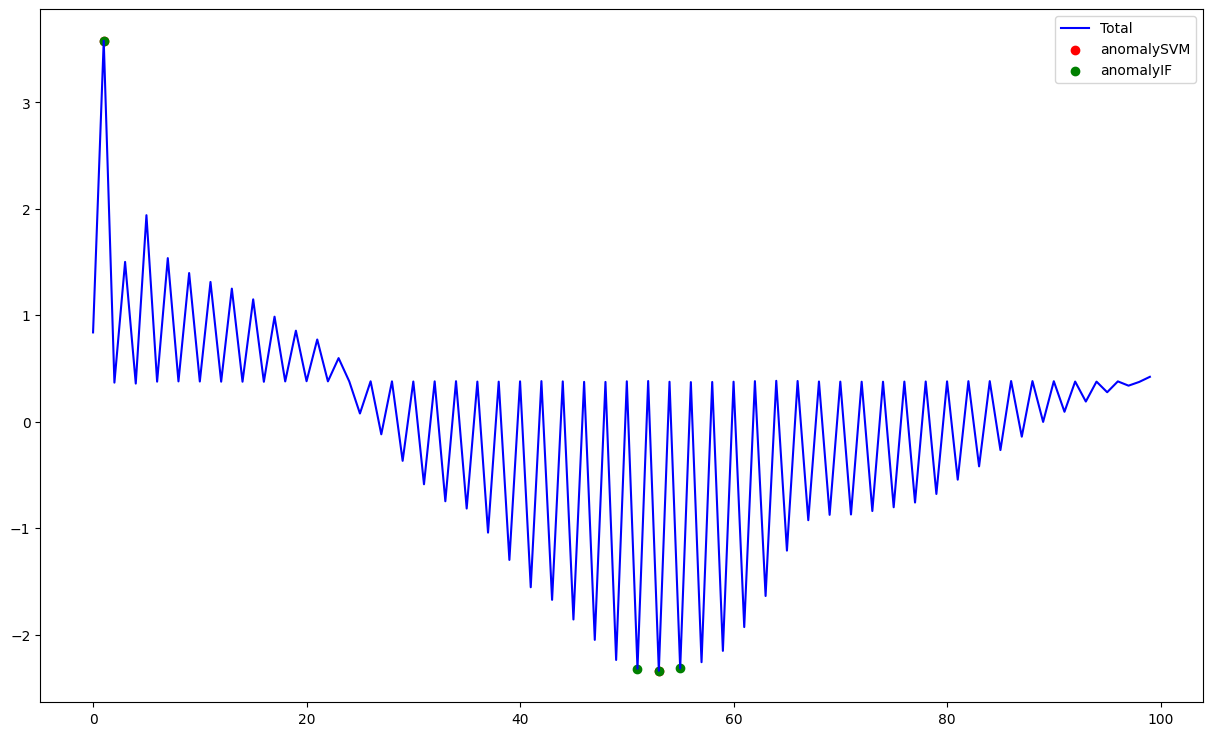

In [20]:
import io
import math
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1 import placeholder, float32, reshape, Variable, random_normal, matmul, global_variables_initializer
from tensorflow.compat.v1 import device, Session, reset_default_graph, reduce_sum, square
from tensorflow.compat.v1.train import AdamOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, chi2

# For TensorFlow 2.x, use these imports
from tensorflow.compat.v1.nn import dynamic_rnn  # Use this for dynamic_rnn in TensorFlow 2.x

from tensorflow.keras.layers import LSTMCell, StackedRNNCells, RNN

# Disable eager execution to make it work like TensorFlow 1.x
tf.compat.v1.disable_eager_execution()
full_path = f'C:/Users/vigne/OneDrive/Documents/ML/Predictive-Maintenance-master/Predictive-Maintenance-master/dataset/raw_data/part-00000-2406b7f9-85fd-430d-a6df-d29212f28d0e-c000.csv'
def loadCSV():
    folder_path = 'C:/Users/vigne/OneDrive/Documents/ML/Predictive-Maintenance-master/Predictive-Maintenance-master/dataset/raw_data'
    file_name = 'part-00000-d6f2018b-b707-4246-82b2-a60e146f330c-c000.csv'
    full_path = f'{folder_path}/{file_name}'

    # Load the CSV file
    df = pd.read_csv(full_path).sort_values('TimeStamp', ascending=True).reset_index(drop=True)
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

    # Print the column names to verify them
    print(df.columns)

    # Drop specific columns, checking if they exist
    columns_to_drop = [
        '::[scararobot]Ax_J1.PositionCommand', '::[scararobot]Ax_J1.TorqueFeedback',
        '::[scararobot]Ax_J2.PositionCommand', '::[scararobot]Ax_J2.TorqueFeedback',
        '::[scararobot]Ax_J3.TorqueFeedback', '::[scararobot]Ax_J6.TorqueFeedback',
        '::[scararobot]ScanTimeAverage', '::[scararobot]Ax_J6.PositionCommand',
        '::[scararobot]Ax_J3.PositionCommand'
    ]
    # Use a list comprehension to filter out any columns that do not exist in the DataFrame
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    df.drop(columns_to_drop, axis=1, inplace=True)
    df['Total'] = df.select_dtypes(include=['float64', 'float32']).apply(np.sum, axis=1)

    return pd.Series(df['Total'])

def featureSelect(df):
  x = df.iloc[0:, 1: 20].values
  y = df.iloc[0:, 20: 21].values.flatten()
  y = np.array(y).astype(int)
  
  SelBest = SelectKBest(chi2, k = 10)
  SelBest.fit_transform(x, y)
  choosed_features = list(SelBest.get_support())
  f_df = df.iloc[0:, 0: 1]
  for index, fea in enumerate(choosed_features):
    if fea == True:
      f_df[str(index)] = df.iloc[0:, index]
  
  f_df['Total'] = f_df.select_dtypes(include = ['float64', 'float32']).apply(lambda row: np.sum(row), axis = 1)
  tensor = pd.Series(f_df['Total'])
  return tensor

def prepareData(num_periods, f_horizon, TS, test_size = 1):
  #create our training input data set "X"
  x_data = TS[:(len(TS)-(len(TS) % num_periods))]
  x_batches = x_data.reshape(-1, num_periods, 1)

  #create our training output dataset "y"
  y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
  print (y_data)
  print (len(y_data))
  y_batches = y_data.reshape(-1, num_periods, 1)
  print (len(y_batches))
  
  #create our test X and y data
  test_x_setup = TS[-(num_periods * test_size + f_horizon):]
  testX = test_x_setup[:num_periods * test_size].reshape(-1, num_periods, 1)
  testY = TS[-(num_periods * test_size):].reshape(-1, num_periods, 1)
  print (testX.shape)
  print (testX[:,(num_periods-1):num_periods])
  print (testY.shape)
  print (testY[:,(num_periods-1):num_periods])
  return x_batches, y_batches, testX, testY

def RNN_LSTM(num_periods, input_size, hidden_number, output_size):
    X = placeholder(float32, [None, num_periods, input_size], name="X")
    Y = placeholder(float32, [None, num_periods, output_size], name="Y")

    LSTM_cell_1 = LSTMCell(units=hidden_number, activation='tanh')
    LSTM_cell_2 = LSTMCell(units=100)
    stacked_lstm_cell = StackedRNNCells([LSTM_cell_1, LSTM_cell_2])

    rnn_layer = RNN(stacked_lstm_cell, return_sequences=True)
    lstm_output = rnn_layer(X)

    weight = Variable(random_normal([100, 1]))
    bias = Variable(random_normal([1]))
    stacked_rnn_output = reshape(lstm_output, [-1, hidden_number])
    stacked_outputs = matmul(stacked_rnn_output, weight) + bias
    f_outputs = reshape(stacked_outputs, [-1, num_periods, output_size])

    return f_outputs, X, Y


def Train(lr, train_op, cost, epochs, dev, X, Y, x_batches, y_batches, X_test, f_outputs):
    init_g = global_variables_initializer()
    loss = []
    saver = tf.compat.v1.train.Saver()  # Create a saver object
    with device(dev):
        with Session() as session:
            session.run(init_g)
            for ep in range(epochs):
                session.run(train_op, feed_dict={X: x_batches, Y: y_batches})
                if ep % 10 == 0:
                    mse = cost.eval(session=session, feed_dict={X: x_batches, Y: y_batches})
                    mse = math.sqrt(mse)
                    if ep % 100 == 0:
                        print(ep, "\tMSE:", mse)
                    loss.append(mse)
            y_pred = session.run(f_outputs, feed_dict={X: X_test})
            # Save the model
            saver.save(session, 'C:/Users/vigne/OneDrive/Documents/ML/Predictive-Maintenance-master/Predictive-Maintenance-master/saved_model/my_model')
    return session, y_pred, loss


#Plot our test y data and our y-predicted forecast
def plotPred(y_pred, Y_test):
  plt.title("Forecast vs Actual", fontsize=14)
  plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
  plt.legend(loc="upper right")
  plt.xlabel("Time Periods")
  plt.show()
  return

def plotLoss(loss):
  plt.title("Training Loss", fontsize=14)
  plt.plot(loss)
  plt.xlabel("Time Periods")
  plt.show()
  return

#anomaly detection
def anomalyDetection(trainset, pred, outliers_fraction, model='SVM'):
    if model == 'SVM':
        m = OneClassSVM(nu=0.95 * outliers_fraction, kernel="rbf", gamma='scale')
    elif model == 'IF':
        m = IsolationForest(contamination=outliers_fraction)
    
    # Ensure both datasets contain the same columns
    trainset = trainset[['Total']]
    pred = pred.rename(columns={'Prediction': 'Total'})  # Renaming for consistency
    
    m.fit(trainset)
    pred['anomaly'] = m.predict(pred[['Total']])
    anomalies = pred[pred['anomaly'] == -1]
    pred = pred.drop(columns=['anomaly'])

    return anomalies, pred

def plotAD(pred, SVM, IF):
  fig, ax = plt.subplots(figsize=(15,9))

  ax.plot(pred['Total'], color='blue', label = 'Total')
  ax.scatter(list(SVM.index.values), list(SVM.Total.values), color = 'red', label = 'anomalySVM')
  ax.scatter(list(IF.index.values), list(IF.Total.values), color = 'green', label = 'anomalyIF')
  plt.legend(loc = 'upper right')
  plt.show()
  return

if __name__ == '__main__':
  #tensor = featureSelect(loadCSV())
  tensor = loadCSV()
  num_periods = 100
  f_horizon = 1       #number of periods into the future we are forecasting
  TS = np.array(tensor)   #convert time series object to an array

  x_batches, y_batches, X_test, Y_test = prepareData(num_periods, f_horizon, TS)

  #set up model parameters
  reset_default_graph()   #reset graph
  input_size = 1            #number of vectors submitted
  hidden_number = 100          #number of neurons
  output_size = 1            #number of output vectors

  f_outputs, X, Y = RNN_LSTM(num_periods, input_size, hidden_number, output_size)

  #set up training parameters
  learning_rate = 0.005   #learning rate
  cost = reduce_sum(square(f_outputs - Y), name = 'cost')    #define the cost function
  optimizer = AdamOptimizer(learning_rate = learning_rate)          #gradient descent method
  train_op = optimizer.minimize(cost)          #train the result of the application of the cost_function
  epochs = 1000    #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

  session, y_pred, loss = Train(learning_rate, train_op, cost, epochs, '/device:GPU:0', X, Y, x_batches, y_batches, X_test, f_outputs)

  DIR="C:/Users/vigne/OneDrive/Documents/ML/Predictive-Maintenance-master/Predictive-Maintenance-master"  #path where the model will be saved
  #tf.saved_model.simple_save(session, DIR,
  #                         inputs={"X": X},
  #                         outputs={"outputs": f_outputs})

  plotPred(y_pred, Y_test)
  plotLoss(loss)
  
  #prepare for anomaly detection
  pred = pd.DataFrame(np.ravel(y_pred), columns = ['Prediction'])
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(pred)
  pred = pd.DataFrame(np_scaled, columns = ['Prediction'])

  testDF = pd.DataFrame(TS, columns = ['Total'])
  testDF_scaled = scaler.fit_transform(testDF)
  testDF = pd.DataFrame(testDF_scaled, columns = ['Total'])

  SVM, pred = anomalyDetection(testDF, pred, 0.002)
  IF, pred = anomalyDetection(testDF, pred, 0.01, 'IF')
  plotAD(pred, SVM, IF)

  
  
  



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, chi2

# Ensure TensorFlow is running in eager mode (which is default in TF 2.x)
tf.config.run_functions_eagerly(True)

def loadCSV():
    folder_path = 'C:/Users/vigne/OneDrive/Documents/ML/Predictive-Maintenance-master/Predictive-Maintenance-master/dataset/raw_data'
    file_name = 'part-00000-d6f2018b-b707-4246-82b2-a60e146f330c-c000.csv'
    full_path = f'{folder_path}/{file_name}'
    df = pd.read_csv(full_path).sort_values('TimeStamp', ascending=True).reset_index(drop=True)
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
    columns_to_drop = [
        '::[scararobot]Ax_J1.PositionCommand', '::[scararobot]Ax_J1.TorqueFeedback',
        '::[scararobot]Ax_J2.PositionCommand', '::[scararobot]Ax_J2.TorqueFeedback',
        '::[scararobot]Ax_J3.TorqueFeedback', '::[scararobot]Ax_J6.TorqueFeedback',
        '::[scararobot]ScanTimeAverage', '::[scararobot]Ax_J6.PositionCommand',
        '::[scararobot]Ax_J3.PositionCommand'
    ]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)
    df['Total'] = df.select_dtypes(include=['float64', 'float32']).sum(axis=1)
    return df['Total']

def featureSelect(df):
    x = df.iloc[:, :-1].values
    y = df.iloc[:, -1].astype(int).values
    selector = SelectKBest(chi2, k=10)
    selector.fit_transform(x, y)
    selected_features = df.columns[selector.get_support()]
    f_df = df[selected_features]
    f_df['Total'] = f_df.sum(axis=1)
    return f_df['Total']

def prepareData(TS, num_periods, f_horizon):
    TS = np.array(TS)
    X, y = [], []
    for i in range(len(TS) - num_periods):
        X.append(TS[i:i+num_periods])
        y.append(TS[i+num_periods:i+num_periods+f_horizon])
    return np.array(X), np.array(y)

def build_model(num_periods, hidden_units):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(hidden_units, input_shape=(num_periods, 1), return_sequences=True),
        tf.keras.layers.LSTM(hidden_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(model, X, y, epochs=20, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)
    return model

def anomalyDetection(data, outliers_fraction=0.01):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
    model.fit(data_scaled)
    preds = model.predict(data_scaled)
    anomalies = data[preds == -1]
    return anomalies

# Load and preprocess data
total_series = loadCSV()
X, y = prepareData(total_series, 100, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

# Build and train model
model = build_model(100, 100)  # 100 time steps, 100 LSTM units
model = train_model(model, X, y, epochs=20)

# Predict and detect anomalies
predictions = model.predict(X)
anomalies = anomalyDetection(predictions.flatten(), 0.01)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(total_series.values, label='Data')
plt.scatter(np.arange(len(predictions)), predictions.flatten(), color='r', label='Predictions')
plt.scatter(anomalies, total_series.iloc[anomalies].values, color='k', marker='x', label='Anomalies')
plt.title('Predictions and Anomalies')
plt.legend()
plt.show()


c:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\vigne\OneDrive\Documents\ML\Predictive-Maintenance-master\Predictive-Maintenance-master\myenv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.